<a href="https://colab.research.google.com/github/grmanjar-cmyk/mlb_wrc_plus_model/blob/main/ML_for_swinging_strikes_w_data_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.3 MB/s eta 0:00:00


In [2]:
from pybaseball import statcast
import pandas as pd

# Fetch Statcast data for a specific date range
start_dt = '2025-06-01'
end_dt = '2025-06-08'
sc_data = statcast(start_dt=start_dt, end_dt=end_dt)

# Display the first few rows of the dataframe
print(sc_data.head())

This is a large query, it may take a moment to complete


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.12/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = da

     pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
3568         FF 2025-06-08           96.4           -2.4           5.39   
3672         SV 2025-06-08           86.4          -2.58           5.51   
3728         FF 2025-06-08           97.1          -2.24           5.36   
3904         FF 2025-06-08           96.5          -2.39           5.43   
4033         FF 2025-06-08           96.6          -2.55           5.33   

          player_name  batter  pitcher     events      description  ...  \
3568  Santillan, Tony  666971   663574  field_out    hit_into_play  ...   
3672  Santillan, Tony  666971   663574        NaN             foul  ...   
3728  Santillan, Tony  553993   663574  strikeout  swinging_strike  ...   
3904  Santillan, Tony  553993   663574        NaN  swinging_strike  ...   
4033  Santillan, Tony  553993   663574        NaN    called_strike  ...   

      batter_days_until_next_game  api_break_z_with_gravity  api_break_x_arm  \
3568              

In [9]:
print(sc_data.columns)
"plate_x" in sc_data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in',
       'arm_angle', 'attack_angle', 'attack_direction', 'swing_path_tilt',
       'intercept_ball_minus_batter_pos_x_inches',
       'intercept_ball_minus_batter_pos_y_inches', 'is_swinging_strike'],
      dtype='object', length=119)


True

In [3]:
# --- 1. Define the Target Variable ---
# Create the 'is_swinging_strike' column. It's 1 for a swinging strike, 0 otherwise.
sc_data['is_swinging_strike'] = (sc_data['description'] == 'swinging_strike').astype(int)

In [4]:
# Use .value_counts() to see the count for each outcome
swinging_strike_counts = sc_data['is_swinging_strike'].value_counts()

print("Distribution of Outcomes:")
print(swinging_strike_counts)

Distribution of Outcomes:
is_swinging_strike
0    28028
1     3316
Name: count, dtype: int64


In [5]:
# Let's see all unique values and their counts in the 'description' column
all_outcomes = sc_data['description'].value_counts()

print("All Pitch Outcomes in the Dataset:")
print(all_outcomes)

All Pitch Outcomes in the Dataset:
description
ball                       10407
foul                        5667
hit_into_play               5549
called_strike               5077
swinging_strike             3316
blocked_ball                 656
foul_tip                     357
swinging_strike_blocked      163
hit_by_pitch                  78
foul_bunt                     57
missed_bunt                   13
bunt_foul_tip                  2
pitchout                       2
Name: count, dtype: int64


In [6]:
# First, define the list of feature columns we want to keep.
feature_columns = [
    'release_speed',
    'release_spin_rate',
    'pfx_x',
    'pfx_z',
    'plate_x',
    'plate_z',
    'balls',
    'strikes',
    'pitch_type',
    'p_throws',
    'stand'
]

In [12]:
#This line of code will return True if every column in feature_columns is found in sc_data, and False if even one of them is missing.
set(feature_columns).issubset(sc_data.columns)

True

In [13]:
# Now, create the model_df DataFrame by selecting only our desired columns from sc_data.
# We also include our target variable in this new DataFrame.
model_df = sc_data[feature_columns + ['is_swinging_strike']].copy()


In [14]:
# Drop rows with missing data from this new DataFrame.
model_df.dropna(inplace=True)

In [18]:
# --- run value_counts() command on model_df ---
swinging_strike_counts = model_df['is_swinging_strike'].value_counts()

print("--- Cleaned DataFrame Head ---")
print(model_df.head())
print("\n--- Distribution of Outcomes in model_df ---")
print(swinging_strike_counts)

--- Cleaned DataFrame Head ---
      release_speed  release_spin_rate  pfx_x  pfx_z  plate_x  plate_z  balls  \
3568           96.4               2397  -1.23   1.05    -0.59     3.02      0   
3672           86.4               2139   0.69  -0.42    -0.88     2.12      0   
3728           97.1               2309  -0.58   1.17    -0.05     3.79      0   
3904           96.5               2373  -0.64   1.24     0.55     3.39      0   
4033           96.6               2390  -1.22   0.87    -0.52     3.26      0   

      strikes pitch_type p_throws stand  is_swinging_strike  
3568        1         FF        R     R                   0  
3672        0         SV        R     R                   0  
3728        2         FF        R     R                   1  
3904        1         FF        R     R                   1  
4033        0         FF        R     R                   0  

--- Distribution of Outcomes in model_df ---
is_swinging_strike
0    28009
1     3313
Name: count, dtype: int

In [19]:
from sklearn.model_selection import train_test_split

# --- 1. One-Hot Encode Categorical Features ---
print("Shape of DataFrame before encoding:", model_df.shape)

# Use pd.get_dummies to convert categorical columns into numerical ones
model_df_encoded = pd.get_dummies(model_df, columns=['pitch_type', 'p_throws', 'stand'], drop_first=True)

print("Shape of DataFrame after encoding:", model_df_encoded.shape)
print("\n--- DataFrame Head After Encoding ---")
print(model_df_encoded.head())

Shape of DataFrame before encoding: (31322, 12)
Shape of DataFrame after encoding: (31322, 26)

--- DataFrame Head After Encoding ---
      release_speed  release_spin_rate  pfx_x  pfx_z  plate_x  plate_z  balls  \
3568           96.4               2397  -1.23   1.05    -0.59     3.02      0   
3672           86.4               2139   0.69  -0.42    -0.88     2.12      0   
3728           97.1               2309  -0.58   1.17    -0.05     3.79      0   
3904           96.5               2373  -0.64   1.24     0.55     3.39      0   
4033           96.6               2390  -1.22   0.87    -0.52     3.26      0   

      strikes  is_swinging_strike  pitch_type_CS  ...  pitch_type_FS  \
3568        1                   0          False  ...          False   
3672        0                   0          False  ...          False   
3728        2                   1          False  ...          False   
3904        1                   1          False  ...          False   
4033        0      

In [20]:
# --- 2. Separate Features (X) and Target (y) ---
# 'X' contains all our predictive features and explicity excludes the target answer with the .drop command
X = model_df_encoded.drop('is_swinging_strike', axis=1)

# 'y' contains only our target variable
y = model_df_encoded['is_swinging_strike']

In [25]:
# --- 3. Split Data into Training and Testing Sets ---
# test_size=0.2 means we'll use 20% of the data for testing
# random_state ensures that we get the same split every time we run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#After running this code, you will have four new DataFrames, which are the essential ingredients for training your model:
# X_train: The features we will use to train the model.
# y_train: The correct outcomes (swinging strike or not) for the training data.
# X_test: The features we will use to evaluate the model's performance on unseen data.
# y_test: The correct outcomes for the testing data, used to score the model's predictions.

In [24]:
# --- 4. Verify the Split ---
print(f"\nTraining data shape (X_train): {X_train.shape}")
print(f"Testing data shape (X_test):  {X_test.shape}")




Training data shape (X_train): (25057, 25)
Testing data shape (X_test):  (6265, 25)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [28]:
# --- 1. Initialize the Model ---
# We create an instance of the Random Forest model.
# n_estimators=100 means it will build 100 decision trees.
# random_state=42 ensures we get the same result every time we run it.
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [29]:
# --- 2. Train the Model ---
# We 'fit' the model to our training data. This is the learning step.
print("Training the Random Forest model...")
model.fit(X_train, y_train)
print("Training complete!")

Training the Random Forest model...
Training complete!


In [30]:
# --- 3. Make Predictions on the Test Data ---
# We use the trained model to predict outcomes for our unseen test data.
predictions = model.predict(X_test)

In [31]:
# --- 4. Evaluate the Model's Performance ---
# Compare the model's predictions to the actual answers (y_test).

# Calculate overall accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Print a more detailed report
print("\n--- Classification Report ---")
print(classification_report(y_test, predictions, target_names=['Not a Swinging Strike', 'Swinging Strike']))


Model Accuracy: 0.8942

--- Classification Report ---
                       precision    recall  f1-score   support

Not a Swinging Strike       0.89      1.00      0.94      5602
      Swinging Strike       0.50      0.00      0.01       663

             accuracy                           0.89      6265
            macro avg       0.70      0.50      0.48      6265
         weighted avg       0.85      0.89      0.85      6265



In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# --- 1. Extract Feature Importances ---
# Get the importance scores from our trained model
#our model is cheating and guessing not a swinging strike every time, getting the overall task right 89% of the time but failing at every swinging strike
#let's look at the feature importances anyway and see if we can learn anything before we try to fix the model flaw
importances = model.feature_importances_
# Get the names of the features
feature_names = X_train.columns

In [35]:
# --- 2. Create a DataFrame for Easy Analysis ---
# Combine feature names and importance scores
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

In [36]:
# --- 3. Print the Top 10 Features ---
print("--- Top 10 Most Important Features ---")
print(feature_importance_df.head(10))

--- Top 10 Most Important Features ---
              feature  importance
5             plate_z    0.163637
1   release_spin_rate    0.147358
4             plate_x    0.143419
0       release_speed    0.139977
2               pfx_x    0.138733
3               pfx_z    0.137046
6               balls    0.037412
7             strikes    0.026374
24            stand_R    0.017682
23         p_throws_R    0.011279


/tmp/ipython-input-2205416874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


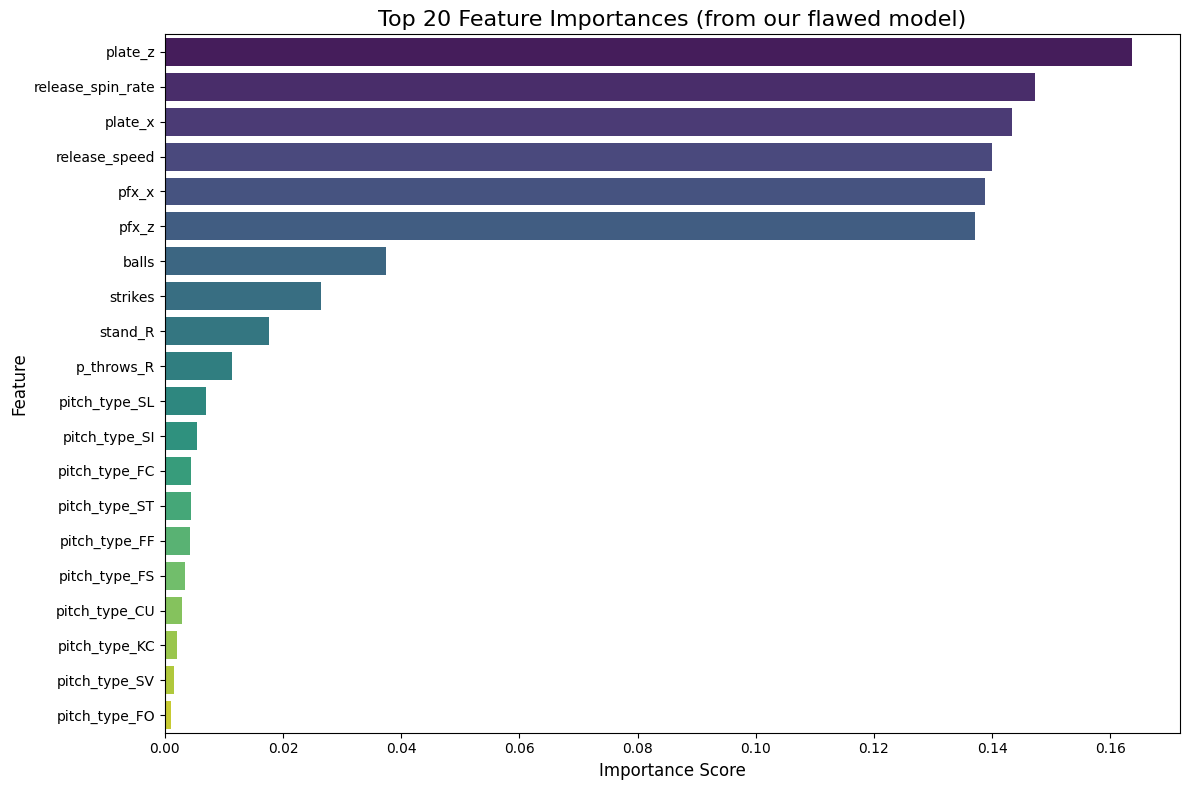

In [37]:
# --- 4. Create the Visualization ---
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')

plt.title('Top 20 Feature Importances (from our flawed model)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
# Let's use our model_df DataFrame which is already cleaned
# Group by the outcome and then describe the release_spin_rate for each group
# question- does it look takes (is_swinging_strike = 0) are highly correlated with high spin?, maybe not per the stats below

spin_rate_by_outcome = model_df.groupby('is_swinging_strike')['release_spin_rate'].describe()

print(spin_rate_by_outcome)

                      count         mean         std    min     25%     50%  \
is_swinging_strike                                                            
0                   28009.0  2281.479025  349.021803   13.0  2143.0  2307.0   
1                    3313.0  2292.099909   405.92956  272.0  2127.0  2343.0   

                       75%     max  
is_swinging_strike                  
0                   2478.0  3378.0  
1                   2542.0  3424.0  


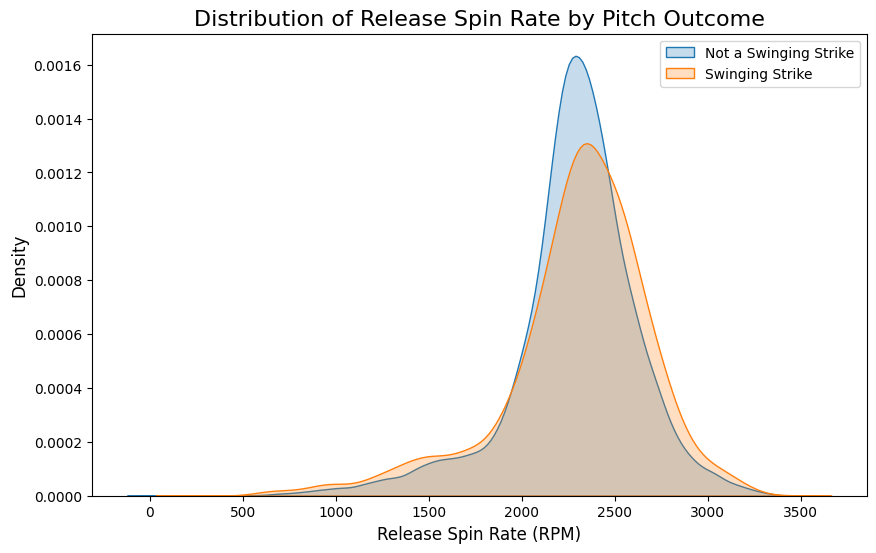

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the distribution of spin rate for non-swinging strikes
sns.kdeplot(model_df[model_df['is_swinging_strike'] == 0]['release_spin_rate'], label='Not a Swinging Strike', fill=True)

# Plot the distribution of spin rate for swinging strikes
sns.kdeplot(model_df[model_df['is_swinging_strike'] == 1]['release_spin_rate'], label='Swinging Strike', fill=True)

plt.title('Distribution of Release Spin Rate by Pitch Outcome', fontsize=16)
plt.xlabel('Release Spin Rate (RPM)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [40]:
# Group by both pitch type AND the outcome, then describe the spin rate
spin_rate_by_pitch_and_outcome = model_df.groupby(['pitch_type', 'is_swinging_strike'])['release_spin_rate'].describe()

# Let's just look at the mean for clarity
print(spin_rate_by_pitch_and_outcome['mean'])

pitch_type  is_swinging_strike
CH          0                     1798.612789
            1                     1824.066964
CS          0                     2429.363636
            1                          2544.0
CU          0                     2604.101957
            1                     2678.760684
EP          0                     1252.740741
FA          0                     1838.969697
FC          0                     2400.722988
            1                     2432.161017
FF          0                     2317.887156
            1                     2328.695163
FO          0                          1214.0
            1                     1193.909091
FS          0                     1397.573006
            1                     1327.364238
KC          0                     2520.361702
            1                     2449.534247
KN          0                           196.0
            1                           272.0
PO          0                          2398.0
SI 

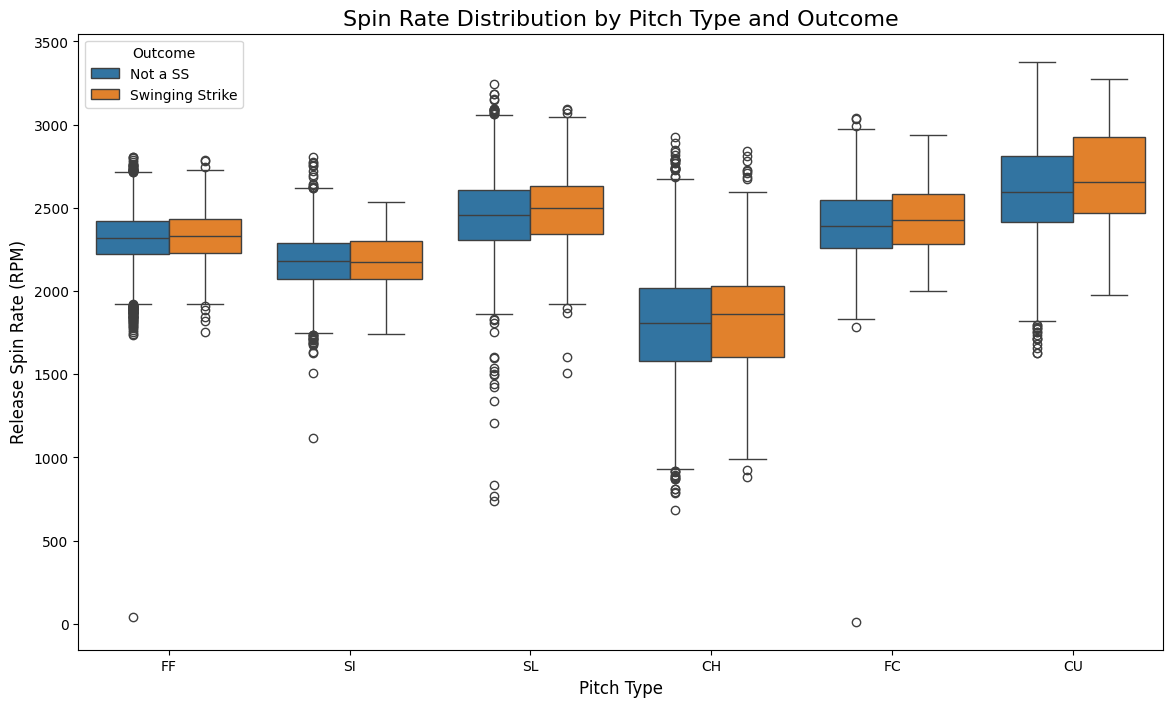

In [42]:
# Filter the DataFrame (this part is the same)
common_pitches = model_df['pitch_type'].value_counts().head(6).index
filtered_df = model_df[model_df['pitch_type'].isin(common_pitches)]

plt.figure(figsize=(14, 8))

# additional code added from Google AI studio here and elsewhere, this section was to fix legend color after a conflict between matplotlib and seaborn
# 1. We assign the plot to a variable, 'ax', so we can access its elements
ax = sns.boxplot(data=filtered_df, x='pitch_type', y='release_spin_rate', hue='is_swinging_strike', order=common_pitches)

# 2. We get the handles and labels that Seaborn automatically created
handles, labels = ax.get_legend_handles_labels()

# 3. We set the legend on the plot, using the original handles (the colored squares)
#    but providing our new, more descriptive labels.
ax.legend(handles=handles, labels=['Not a SS', 'Swinging Strike'], title='Outcome')
# --- END FIX ---

plt.title('Spin Rate Distribution by Pitch Type and Outcome', fontsize=16)
plt.xlabel('Pitch Type', fontsize=12)
plt.ylabel('Release Spin Rate (RPM)', fontsize=12)
plt.show()